# Norfolk processing Bowen 

Bases on [Energy Assement]('SPG- EA24-05927 Bowen Energy Audit Report_Final.pdf')

## Electricity

In [4]:
import pandas as pd

# 1. Read the CSV
df = pd.read_csv('Bowen_EA_ElectricConsumption.csv')

# 2. Drop any 'Total' rows
df = df[df['month'].str.lower() != 'total'].copy()

# 3. Map month names to numbers
month_map = {
    'January':   1, 'February':  2, 'March':     3, 'April':    4,
    'May':       5, 'June':      6, 'July':      7, 'August':   8,
    'September': 9, 'October':  10, 'November': 11, 'December':12
}
df['month_number'] = df['month'].map(month_map)

# 4. Ensure numeric types
df[['year','cost','kwh']] = df[['year','cost','kwh']].apply(pd.to_numeric)

# 5. Compute the Sept & Oct 2023 average
mask = (df['year'] == 2023) & (df['month_number'].isin([9, 10]))
n_months = mask.sum()                      # should be 2
cost_sum = df.loc[mask, 'cost'].sum()
kwh_sum  = df.loc[mask, 'kwh'].sum()

cost_fixed_val = cost_sum / n_months       # avg CAD/month
kwh_fixed_val  = kwh_sum  / n_months       # avg kWh/month

# 6. Broadcast those averages into new columns
df.loc[mask,'cost_fixed'] = cost_fixed_val
df.loc[mask,'kwh_fixed']  = kwh_fixed_val

df['cost_fixed'] = df['cost_fixed'].fillna(df.cost)
df['kwh_fixed'] = df['kwh_fixed'].fillna(df.kwh)

# 7. (Re)compute cost_per_kwh from the fixed baseline
df['cost_per_kwh_fixed'] = df['cost_fixed'] / df['kwh_fixed']

df['year_str'] = df['year'].astype(str)  # Convert year to string for coloring


# 8. Inspect & save
df.to_csv('Bowen_EA_ElectricConsumption_processed.csv', index=False)
df


,year,month,cost,kwh,month_number,cost_fixed,kwh_fixed,cost_per_kwh_fixed,year_str
0,2023,June,1791,9522,6,1791.0,9522.0,0.188091,2023
1,2023,July,1717,10238,7,1717.0,10238.0,0.167709,2023
2,2023,August,1984,9977,8,1984.0,9977.0,0.198857,2023
3,2023,September,642,10285,9,1668.5,9469.0,0.176207,2023
4,2023,October,2695,8653,10,1668.5,9469.0,0.176207,2023
5,2023,November,1579,8102,11,1579.0,8102.0,0.194890,2023
6,2023,December,1635,9300,12,1635.0,9300.0,0.175806,2023
8,2024,January,2038,11234,1,2038.0,11234.0,0.181414,2024
9,2024,February,1513,8554,2,1513.0,8554.0,0.176876,2024
10,2024,March,1610,10131,3,1610.0,10131.0,0.158918,2024


In [10]:
import plotly.express as px



def plot_monthly_by_year(
    df,
    y_col,
    month_col: str = "month_number",
    year_col: str = "year_str",
    title: str = None,
    n_stds: int = 2
):
    """
    Creates and shows a Plotly grouped bar chart of monthly values by year,
    with horizontal lines marking the overall mean and ±1 standard deviation.
    
    Parameters:
    - df: pandas DataFrame containing your data.
    - y_col: column name for the values to plot on the y-axis.
    - month_col: column name for month numbers (1–12).
    - year_col: column name for the year (as string) used for color grouping.
    - title: optional chart title.
    """
    # Compute overall mean and standard deviation
    mean_val = df[y_col].mean()
    std_val  = df[y_col].std()
    upper    = mean_val + std_val*n_stds
    lower    = mean_val - std_val*n_stds

    # Build the grouped bar chart
    fig = px.bar(
        df,
        x=month_col,
        y=y_col,
        color=year_col,
        labels={
            month_col: "Month",
            y_col: y_col.replace("_", " ").title(),
            year_col: "Year"
        },
        title=title or f"{y_col.replace('_', ' ').title()} by Month & Year",
        barmode="group"
    )

    # Add horizontal lines for mean and ±1σ
    fig.add_hline(
        y=mean_val,
        line_dash="dash",
        annotation_text=f"Mean ({mean_val:.3f})",
        annotation_position="top left"
    )
    fig.add_hline(
        y=upper,
        line_dash="dot",
        annotation_text=f"+{n_stds}σ ({upper:.3f})",
        annotation_position="top right"
    )
    fig.add_hline(
        y=lower,
        line_dash="dot",
        annotation_text=f"-{n_stds}σ ({lower:.3f})",
        annotation_position="bottom right"
    )

    # Use abbreviated month names on the x-axis
    fig.update_layout(
        xaxis=dict(
            tickmode="array",
            tickvals=list(range(1, 13)),
            ticktext=[
                "Jan", "Feb", "Mar", "Apr", "May", "Jun",
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
            ]
        )
    )

    fig.show()


In [11]:
plot_monthly_by_year(df, "cost_per_kwh_fixed", title="Monthly Cost Per KWh")

In [12]:
plot_monthly_by_year(df, "kwh_fixed", title="Monthly KWh")

In [4]:
import pandas as pd

def summarize_stats(
    df: pd.DataFrame,
    cols: list[str],
    month_col: str = "month_number",
    freq: str | None = "M"
) -> tuple[pd.DataFrame, pd.Series]:
    """
    Returns (monthly_stats, overall_stats) for the specified columns.

    - monthly_stats: DataFrame indexed by month_number (1–12) with
      sum, mean, median, std, min, max, count, cv (std/mean).
    - overall_stats: Series with the same metrics across the entire DataFrame.
    
    Parameters:
    - df: DataFrame containing your data.
    - cols: list of column names to summarize.
    - month_col: column name that holds month numbers (1–12).
    - freq: if 'M', group by month; if None, skip monthly grouping.
    """
    # 1) Overall stats
    overall = df[cols].agg(['sum','mean','median','std','min','max','count'])
    overall.loc['cv'] = overall.loc['std'] / overall.loc['mean']

    # 2) Monthly stats
    if freq == "M":
        monthly = df.groupby(month_col)[cols]\
                    .agg(['sum','mean','median','std','min','max','count'])\
                    .sort_index()
        # flatten multiindex columns
        monthly.columns = [
            f"{col}_{stat}" for col, stat in monthly.columns
        ]
        # add cv columns
        for col in cols:
            monthly[f"{col}_cv"] = monthly[f"{col}_std"] / monthly[f"{col}_mean"]
    else:
        monthly = pd.DataFrame()

    return monthly, overall

# --- example usage ---

# Define which columns you want stats for:
stats_cols = ["cost_fixed", "kwh_fixed", "cost_per_kwh_fixed"]

# Compute
monthly_stats, overall_stats = summarize_stats(df, stats_cols)

# Inspect
print("=== Monthly Stats ===")
monthly_stats



=== Monthly Stats ===


,cost_fixed_sum,cost_fixed_mean,cost_fixed_median,cost_fixed_std,cost_fixed_min,cost_fixed_max,cost_fixed_count,kwh_fixed_sum,kwh_fixed_mean,kwh_fixed_median,...,cost_per_kwh_fixed_sum,cost_per_kwh_fixed_mean,cost_per_kwh_fixed_median,cost_per_kwh_fixed_std,cost_per_kwh_fixed_min,cost_per_kwh_fixed_max,cost_per_kwh_fixed_count,cost_fixed_cv,kwh_fixed_cv,cost_per_kwh_fixed_cv
month_number,,,,,,,,,,,,,,,,,,,,,
1,2038.0,2038.0,2038.0,NaN,2038.0,2038.0,1,11234.0,11234.0,11234.0,...,0.181414,0.181414,0.181414,NaN,0.181414,0.181414,1,NaN,NaN,NaN
2,1513.0,1513.0,1513.0,NaN,1513.0,1513.0,1,8554.0,8554.0,8554.0,...,0.176876,0.176876,0.176876,NaN,0.176876,0.176876,1,NaN,NaN,NaN
3,1610.0,1610.0,1610.0,NaN,1610.0,1610.0,1,10131.0,10131.0,10131.0,...,0.158918,0.158918,0.158918,NaN,0.158918,0.158918,1,NaN,NaN,NaN
4,1429.0,1429.0,1429.0,NaN,1429.0,1429.0,1,8379.0,8379.0,8379.0,...,0.170545,0.170545,0.170545,NaN,0.170545,0.170545,1,NaN,NaN,NaN
5,1417.0,1417.0,1417.0,NaN,1417.0,1417.0,1,8620.0,8620.0,8620.0,...,0.164385,0.164385,0.164385,NaN,0.164385,0.164385,1,NaN,NaN,NaN
6,3152.0,1576.0,1576.0,304.055916,1361.0,1791.0,2,17153.0,8576.5,8576.5,...,0.366442,0.183221,0.183221,0.006887,0.178351,0.188091,2,0.192929,0.155907,0.037587
7,1717.0,1717.0,1717.0,NaN,1717.0,1717.0,1,10238.0,10238.0,10238.0,...,0.167709,0.167709,0.167709,NaN,0.167709,0.167709,1,NaN,NaN,NaN
8,1984.0,1984.0,1984.0,NaN,1984.0,1984.0,1,9977.0,9977.0,9977.0,...,0.198857,0.198857,0.198857,NaN,0.198857,0.198857,1,NaN,NaN,NaN
9,1668.5,1668.5,1668.5,NaN,1668.5,1668.5,1,9469.0,9469.0,9469.0,...,0.176207,0.176207,0.176207,NaN,0.176207,0.176207,1,NaN,NaN,NaN


In [5]:
print("\n=== Overall Stats ===")
overall_stats


=== Overall Stats ===


,cost_fixed,kwh_fixed,cost_per_kwh_fixed
sum,21411.000000,120626.000000,2.308256
mean,1647.000000,9278.923077,0.177558
median,1635.000000,9469.000000,0.176207
std,203.986009,998.233562,0.011383
min,1361.000000,7631.000000,0.158918
max,2038.000000,11234.000000,0.198857
count,13.000000,13.000000,13.000000
cv,0.123853,0.107581,0.064108


In [13]:
9278.923077*12


111347.076924

In [12]:
from metalog import metalog
import numpy as np
np.float_ = np.float64


df

,year,month,cost,kwh,month_number,cost_fixed,kwh_fixed,cost_per_kwh_fixed,year_str
0,2023,June,1791,9522,6,1791.0,9522.0,0.188091,2023
1,2023,July,1717,10238,7,1717.0,10238.0,0.167709,2023
2,2023,August,1984,9977,8,1984.0,9977.0,0.198857,2023
3,2023,September,642,10285,9,1668.5,9469.0,0.176207,2023
4,2023,October,2695,8653,10,1668.5,9469.0,0.176207,2023
5,2023,November,1579,8102,11,1579.0,8102.0,0.194890,2023
6,2023,December,1635,9300,12,1635.0,9300.0,0.175806,2023
8,2024,January,2038,11234,1,2038.0,11234.0,0.181414,2024
9,2024,February,1513,8554,2,1513.0,8554.0,0.176876,2024
10,2024,March,1610,10131,3,1610.0,10131.0,0.158918,2024


<Axes: >

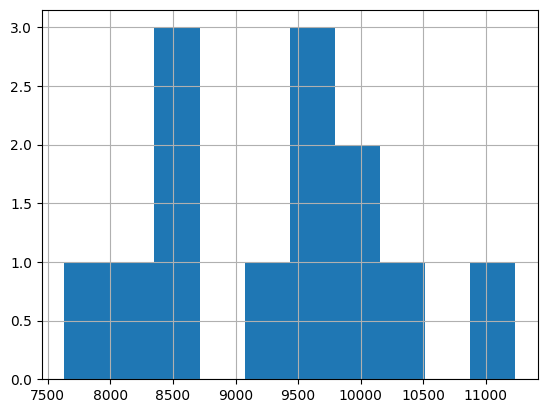

In [23]:
df['kwh_fixed'].hist()

In [ ]:
consumption = np.array(df["kwh_fixed"])

dist = metalog.fit(
    consumption,
    boundedness="u",
    bounds=[6e3, 12e3],
    term_limit=3,
)

KeyboardInterrupt: 

In [29]:
import numpy as np
import pandas as pd

salmon = pd.read_csv("Chinook and forage fish lengths.csv")

# Filtered data for eelgrass vegetation and chinook salmon
salmon = salmon[(salmon['Vegetation'] == 'Eelgrass') & (salmon['Species'] == 'Chinook_salmon')]
# salmon = np.array(salmon['Length'])
salmon 

,Zone,Vegetation,Year,Date,Species,Length,Dominant_age_group,Latitude,Longitude
0,3,Eelgrass,2008,5/27/2008,Chinook_salmon,83,No,48.32099,-122.49460
1,1,Eelgrass,2008,5/28/2008,Chinook_salmon,76,No,48.37636,-122.55731
2,1,Eelgrass,2008,5/28/2008,Chinook_salmon,92,No,48.37636,-122.55731
3,3,Eelgrass,2008,6/25/2008,Chinook_salmon,57,Yes,48.31565,-122.48015
4,3,Eelgrass,2008,6/25/2008,Chinook_salmon,65,Yes,48.31278,-122.48617
...,...,...,...,...,...,...,...,...,...
2424,1,Eelgrass,2009,6/16/2009,Chinook_salmon,72,Yes,48.38291,-122.54931
2425,1,Eelgrass,2009,6/16/2009,Chinook_salmon,74,Yes,48.38291,-122.54931
2454,1,Eelgrass,2009,6/16/2009,Chinook_salmon,81,Yes,48.37383,-122.55555
2455,1,Eelgrass,2009,6/16/2009,Chinook_salmon,96,Yes,48.37383,-122.55555


In [22]:
metalog_salmon = metalog.fit(x=salmon, boundedness='b', bounds=[0, 200], term_limit=10)
